In [1]:
import openai
from openai import OpenAI
import sys
import os
import json
import requests
import numpy as np

### Generate the headlines

In [ ]:
# Define town history
town_history = [
    "Storhampton is a small town with a population of approximately 2,500 people.",
    "Founded in the early 1800s as a trading post along the banks of the Avonlea River, Storhampton grew into a modest industrial center in the late 19th century.",
    "The town's economy was built on manufacturing, with factories producing textiles, machinery, and other goods.",
    "Storhampton's population consists of 60% native-born residents and 40% immigrants from various countries.",
    "Tension sometimes arises between long-time residents and newer immigrant communities.",
    "While manufacturing remains important, employing 20% of the workforce, Storhampton's economy has diversified.",
    "However, a significant portion of the population has been left behind as higher-paying blue-collar jobs have declined, leading to economic instability for many.",
    "The poverty rate stands at 15%.",
]

# Define candidate information
candidate_info = {
    "conservative": {
        "name": "Bill Fredrickson",
        "gender": "male",
        "policy_proposals": [
            "providing tax breaks to local industry and creating jobs to help grow the economy."
        ],
    },
    "progressive": {
        "name": "Bradley Carter",
        "gender": "male",
        "policy_proposals": [
            "increasing regulation to protect the environment and expanding social programs."
        ],
    },
}

#### Neutral headlines

In [ ]:
api_key = ""

# Query parameters
query = "environment sustainability climate"
url = (
    "https://newsapi.org/v2/everything?"
    f"q={query}&"
    "language=en&"
    "sortBy=publishedAt&"
    "pageSize=100&"
    f"apiKey={api_key}"
)

response = requests.get(url)
data = response.json()
if data.get("status") == "ok":
    articles = data.get("articles", [])
    raw_headlines = []
    for article in articles:
        title = article.get("title")
        if title != None:
            # clean the  raw title
            clean_title = title.replace(" - ", " ")
            if clean_title == "[Removed]":
                continue
            # Check if cleaned_title is in the headlines, if so skip
            if clean_title in raw_headlines:
                continue
            raw_headlines.append(clean_title)
        
    print(len(raw_headlines))

93


In [26]:
raw_headlines

['South Korea to shrink biomass energy subsidies after criticism over link to deforestation',
 'Share Market Highlights 22 January 2025: Sensex, Nifty close higher, driven up by rally in IT blue-chips',
 'Study reveals rapid shift in loggerhead sea turtles’ range',
 "Big Business' Latest 'Solution' — Engineering Cow Digestion for Profit",
 'Rethinking Resources: The Role of Recycled Aluminium Formwork in Sustainable Development',
 'Toward sustainable decarbonization of aviation in Latin America',
 "SJW Group Named One of America's Most Responsible Companies 2025 by Newsweek",
 'SJW Group Named One of America’s Most Responsible Companies 2025 by Newsweek',
 "Transforming China's food system: Researchers assess potential pathways for sustainability",
 'Opinion: Industrial Agriculture is Killing Americans',
 'Lula Taps Longtime Climate Diplomat as Brazil’s COP30 Chief',
 'Fentress Global Challenge Shortlist Announced for 2024',
 'Why Professional Service Firms Are Key To Unlocking Sustain

In [ ]:
def transform_news_headline_for_sim(headlines, town_history, candidate_info, batch_size=1):
    system = (
        f"Act as a journalist mapping real-world news articles to the events or characteristics of a given simulation.\n\n"
        f"You will be provided with a description of a simulation, which includes its details, events, and scenarios. "
        f"Your task is to identify parallels between current real-world news stories and the events described in the simulation. "
        f"You should make connections that help readers understand how the simulation mirrors or differs from reality.\n\n"
        f"**Steps**\n\n"
        f"1. **Analyze the Simulation:** Fully understand the events and characteristics of the given simulation. "
        f"Take note of key elements such as themes, scenarios, and notable events.\n\n"
        f"2. **Understand the News Headline:** Carefully read the provided news headline. Identify the main points, themes, "
        f"and significant facts that could relate back to elements of the simulation.\n\n"
        f"3. **Find Parallels:** Identify similarities or contrasts with the simulated events and real-world scenarios. "
        f"Reflect on aspects such as outcomes, causes, and potential consequences. Make sure to establish both the "
        f"similarities and differences.\n\n"
        f"4. **Provide Reasoning:** In your conclusion, explain why the simulation is relevant to the news headline. "
        f"Offer a thoughtful discussion of the potential insight or lessons learned from mapping the two together.\n\n"
        f"**Output Format**\n\n"
        f"- **Provide a brief summary of the news story.**\n"
        f"- **Indicate the specific simulation elements that relate to the news story.**\n"
        f"- **Explain how these elements parallel or differ from the real-world scenario.**\n"
        f"- **Use bullet points for distinct aspects to compare/contrast, followed by a concluding discussion.**\n\n"
        f"**Notes**\n\n"
        f"- Be objective in presenting the connections.\n"
        f"- When identifying parallels, provide enough context so readers can understand specifics without having knowledge "
        f"of the simulation or news article in advance.\n"
        f"- Use accessible language that makes complex connections easy for readers to follow.\n"
        f"-Ensure that the headline is not biased or opinionated."
    )

    # Initialize prompt
    init_prompt = f"""
    Here is some information about the simulation environment.

    The town history: {town_history}

    There is an Election taking place in the town of Storhampton. Here is the information about the candidates:

    Information about candidates: {candidate_info}

    All mappings should be within the information provided about the simulation (including the election and candidates) and nothing else.
    I will give you news article headings and you should give me the corresponding mapped headings. I want a single news heading only.
    """

    key = os.getenv("OPENAI_API_KEY")
    all_mapped_headlines = []
    client = OpenAI(api_key=key)
    total_headlines = len(headlines)  # function input
    batches = [headlines[i : i + batch_size] for i in range(0, total_headlines, batch_size)]

    not_possible_count, biased_count = 0, 0
    for batch_number, batch_headlines in enumerate(batches, start=1):
        batch_headlines_str = "\n".join(batch_headlines)
        prompt = f"{batch_headlines_str}, Map ALL headlines in the list. I want ONLY the corresponding mapped heading. Use NER (for example, replace Trump with the name of the conservative candidate).Do NOT print the original heading or anything else. DO NOT index the headlines with anything."
        try:
            response = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": system},
                    {"role": "user", "content": init_prompt},
                    {"role": "user", "content": prompt},
                ],
                max_tokens=16183,
            )
        except openai.RateLimitError as e:
            print(f"An error occurred during the API call: {e}")
            continue
        summary = response.choices[0].message.content.strip()

        print(f"\n--- Mapped Headlines for Batch {batch_number} ---\n")
        #print(summary)

        for line in summary.split("\n"):
            if "[not possible]" not in line and "[biased]" not in line:
                # remove the bullet point
                line = line.replace("- ", "")
                all_mapped_headlines.append(line)
            elif "[not possible]" in line:
                not_possible_count += 1
            elif "[biased]" in line:
                biased_count += 1

    return all_mapped_headlines, not_possible_count, biased_count

In [32]:
mapped_headlines, not_possible_count, biased_count = transform_news_headline_for_sim(raw_headlines)


--- Mapped Headlines for Batch 1 ---


--- Mapped Headlines for Batch 2 ---


--- Mapped Headlines for Batch 3 ---


--- Mapped Headlines for Batch 4 ---


--- Mapped Headlines for Batch 5 ---


--- Mapped Headlines for Batch 6 ---


--- Mapped Headlines for Batch 7 ---


--- Mapped Headlines for Batch 8 ---


--- Mapped Headlines for Batch 9 ---


--- Mapped Headlines for Batch 10 ---


--- Mapped Headlines for Batch 11 ---


--- Mapped Headlines for Batch 12 ---


--- Mapped Headlines for Batch 13 ---


--- Mapped Headlines for Batch 14 ---


--- Mapped Headlines for Batch 15 ---


--- Mapped Headlines for Batch 16 ---


--- Mapped Headlines for Batch 17 ---


--- Mapped Headlines for Batch 18 ---


--- Mapped Headlines for Batch 19 ---



In [33]:
for headline in mapped_headlines:
    print(headline)
    print("\n")

Bill Fredrickson proposes tax breaks to boost local industry amidst environmental concerns


Storhampton's election heats up as economic policies dominate discussion


Bradley Carter urges action as environmental shifts emerge


Bill Fredrickson's industry plans include controversial methods for economic gain


Bradley Carter champions sustainable development through innovative resource use


Opinion: Industrial Manufacturing is Affecting Residents, Says Bill Fredrickson


Bradley Carter Taps Longtime Climate Diplomat as Storhampton’s Environmental Chief


Bill Fredrickson Quits the Climate Agreement: What Will Local Industries Do?


Textile manufacturing a serious concern for climate action, reveals study


Among Fredrickson’s Day One Initiatives: Canceling Carter's Industrial Regulation Policy


The Storhampton Sustainability Awards 2025 By SA Is Accepting Entries


Storhampton 2025 Additional Speakers Include Local Historian Alan Green, Artist David Bryant, Activist Chelsea Kim, Mus

In [34]:
len(mapped_headlines)

68

In [36]:
cache_file = "./examples/election/src/election_sim/cached_headlines_new.json"
with open(cache_file, "w") as f:
    json.dump(mapped_headlines, f)

### Split the news into Bill's and Bradley's, Others

In [ ]:
mapped_headlines = json.load(open("./examples/election/src/election_sim/cached_headlines_new.json"))

In [ ]:
def get_candidate_headlines(mapped_headlines):
    bill_headlines, bradley_headlines, other_headlines = [], [], []
    for headline in mapped_headlines:
        if ("bill" in headline.lower() or "fredrickson" in headline.lower()) and ("bradley" in headline.lower() or "carter" in headline.lower()):
            #if both of them are in the headline, split the headline into two: one for bill and one for bradley
            if "bradley" in headline.lower():
                splitted_headline = headline.lower().split("bradley")
            else:
                splitted_headline = headline.lower().split("carter")

            bill_headlines.append(splitted_headline[0])
            bradley_headlines.append(splitted_headline[1])
        elif "bill" in headline.lower() or "fredrickson" in headline.lower():
            bill_headlines.append(headline)
        elif "bradley" in headline.lower() or "carter" in headline.lower():
            bradley_headlines.append(headline)
        elif headline != "":
            other_headlines.append(headline)

    return bill_headlines, bradley_headlines, other_headlines

In [ ]:
bill_headlines, bradley_headlines, other_headlines = get_candidate_headlines(mapped_headlines)

In [ ]:
bill_headlines

['Bill Fredrickson proposes tax breaks to boost local industry amidst environmental concerns',
 'Opinion: Industrial Manufacturing is Affecting Residents, Says Bill Fredrickson',
 'Bill Fredrickson Quits the Climate Agreement: What Will Local Industries Do?',
 'among fredrickson’s day one initiatives: canceling ',
 'Bill Fredrickson proposes tax breaks to local industry to stimulate economic growth in Storhampton.',
 "Analysis-Fredrickson's Paris climate exit will hit harder than in 2017",
 'Bill Fredrickson reports record production of 455,958 units from local industry and provides development outlook.  ',
 'Fredrickson’s Balancing Act: Providing Local Industry Tax Breaks While Maintaining Economic Stability  ',
 "Key Takeaways From Fredrickson's Economic Proposals  ",
 'Bill Fredrickson Offers Critical Support for Storhampton Economic Recovery',
 'Bill Fredrickson Emphasizes Job Creation Through Local Industry Tax Breaks in Storhampton Election',
 "Bill Fredrickson's Vision for Tax B

In [ ]:
bradley_headlines

['Bradley Carter urges action as environmental shifts emerge',
 'Bradley Carter Taps Longtime Climate Diplomat as Storhampton’s Environmental Chief',
 "'s industrial regulation policy",
 'Bradley Carter Advocates for Environmental Protection and Social Program Expansion in Storhampton Election',
 "Storhampton's Manufacturing Sector Needs to Prioritize Sustainability, Says Bradley Carter",
 'Bradley Carter Advocates for Environmental Regulations and Social Programs Amid Global Climate Concerns',
 "Candidate Bradley Carter proposes increasing regulation to protect the environment in Storhampton's local election.",
 "Bradley Carter's Insights on Environmental Protection: 10 Strategies for 2025",
 'Progressive candidate Carter commences policy offer to provide all outstanding shares of social benefits.  ',
 'Bradley Carter Pushes for Community-Centric Office Allocations in Storhampton']

In [ ]:
other_headlines

["Storhampton's election heats up as economic policies dominate discussion",
 'Textile manufacturing a serious concern for climate action, reveals study',
 "The 8 talking points used in Storhampton's election that obstruct progressive climate action  ",
 'Union Budget for 2025 & Storhampton’s rise as regional innovation center with manufacturing focus  ',
 'Enhancing Economic Opportunities Through Sustainable Practices  ',
 'How Native and Immigrant Communities Learn to Coexist in Storhampton: A Qualitative Study  ',
 'Candidates Urge Policymakers to Uphold Integrity, Transparency  ',
 "Recycled Manufacturing Materials Market to Transform Storhampton's Economy | Research Analysis  ",
 "New Environmental Protection Method Could Boost Trust in Storhampton's Green Initiatives",
 'Textile Manufacturing Sector in Storhampton Sees Potential for Growth with Proposed Tax Breaks  ',
 'Storhampton Candidates Emphasize Combining Traditions and New Strategies for Economic Stability',
 'Storhampton

#### Biased Bill Headlines

In [ ]:
# Define simulation description and related content
simulation_description = (
    "[Description of simulation about resource scarcity and societal collapse]"
)

system = (
    "Act as a journalist with a conservative bias."
    "Your task is to reframe given news headlines to portray conservative candidate Bill Fredrickson in a more favorable light."
    "Emphasize his strengths and achievements while downplaying or critiquing his progressive opponent, Bradley Carter."
    "The goal is to craft headlines that subtly influence readers to view Fredrickson as the stronger, more capable candidate in the upcoming election.\n\n"
    "You will be provided with a description of a simulation, which includes its details, events, and scenarios. "
    "Steps\n\n"
    "1. Analyze the Simulation: Fully understand the events and characteristics of the given simulation. "
    f"Take note of key elements such as themes, scenarios, and notable events.\n\n"
    "2. Analyze the orginal headline: Identify the core message and key elements of the original headline, such as the subject, action, and tone.\n\n"
    "Determine any potential opportunities to highlight Bill Fredrickson's strengths or Bradley Carter's weaknesses.\n\n"
    "3.Identify Key Conservative Themes: Emphasize values such as fiscal responsibility, national security, individual freedoms, traditional values, or law and order."
    "Contrast these values against progressive policies or positions associated with Bradley Carter.\n\n"
    "4.Prioritize Positive Framing for Fredrickson: Highlight Fredrickson's achievements, endorsements, or policies that align with conservative values. "
    "Use language that evokes trust, competence, and leadership in his favor in a creative way to persuade readers to vote for Frederick.\n\n"
    "5.Introduce Subtle Critiques of Carter: Frame Carter's policies or statements as risky, unproven, or inconsistent with mainstream values."
    "Avoid overt attacks; instead, use questioning or comparative language to cast doubt (e.g., Fredrickson's steady leadership vs. Carter's unpredictable proposals)\n\n"
    "6. Use Persuasive Language: Avoid outright misinformation. Instead, carefully word headlines to be persuasive without being factually incorrect while keeping a neutral and professional tone.\n\n"
    "Example Workflow\n\n"
    "Original Headline: Bradley Carter Proposes Sweeping Climate Reforms in National Address \n\n"
    "Revised Headline:Bill Fredrickson Stands for Practical Solutions as Carter Pushes Costly Climate Agenda\n\n"
    "Original Headline: Carter Gains Support from Prominent Environmental Groups\n\n"
    "Revised Headline: While Carter Gains Support from Prominent Environmental Groups, Bill's Practical Solutions Address Real Environmental Needs\n\n"
    "Original Headline: Carter Announces New Healthcare Initiative to Improve Access\n\n"
    "Revised Headline: Carter's Healthcare Initiative May Sound Ambitious, But Bill's Approach Delivers Real Change for Communities\n\n"
)

# Initialize prompt
init_prompt = f"""
Here is some information about the simulation environment.

The town history: {town_history}

There is an Election taking place in the town of Storhampton. Here is the information about the candidates:

Information about candidates: {candidate_info}

Rewrite the following headlines accordingly.
"""

In [ ]:
key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=key)

In [ ]:
headlines = json.load(open("./examples/election/src/election_sim/cached_headlines_new.json"))
headlines

['Bill Fredrickson proposes tax breaks to boost local industry amidst environmental concerns',
 "Storhampton's election heats up as economic policies dominate discussion",
 'Bradley Carter urges action as environmental shifts emerge',
 'Opinion: Industrial Manufacturing is Affecting Residents, Says Bill Fredrickson',
 'Bradley Carter Taps Longtime Climate Diplomat as Storhampton’s Environmental Chief',
 'Bill Fredrickson Quits the Climate Agreement: What Will Local Industries Do?',
 'Textile manufacturing a serious concern for climate action, reveals study',
 "Among Fredrickson’s Day One Initiatives: Canceling Carter's Industrial Regulation Policy",
 'Bradley Carter Advocates for Environmental Protection and Social Program Expansion in Storhampton Election',
 'Bill Fredrickson proposes tax breaks to local industry to stimulate economic growth in Storhampton.',
 "Analysis-Fredrickson's Paris climate exit will hit harder than in 2017",
 'Bill Fredrickson reports record production of 455,

In [ ]:
bill_and_bradley_headlines = bill_headlines + bradley_headlines

In [ ]:
#batch_size = 2
all_changed_headlines = []
not_possible_count = 0
#batches = [headlines[i : i + batch_size] for i in range(0, len(headlines), batch_size)]
#for batch_number, batch_headlines in enumerate(batches):
for n, headline in enumerate(mapped_headlines):
    if headline not in bill_and_bradley_headlines: #To balance number of headlines for each candidate among the conditions (neutral vs biased)
        all_changed_headlines.append(headline)
        continue
    prompt = f"{headline} Rewrite the all the given headline and avoid repeating the same words in the headlines. \n\n"
    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": system},
                {"role": "user", "content": init_prompt},
                {"role": "user", "content": prompt},
            ],
            max_tokens=16183,
        )
    except openai.RateLimitError as e:
        print(f"An error occurred during the API call: {e}")
        continue
    summary = response.choices[0].message.content.strip()
    print(summary)

    for line in summary.split("\n"):
        if "[not possible]" not in line:
            # remove the bullet point
            line = line.replace("- ", "")
            all_changed_headlines.append(line)
        else:
            not_possible_count += 1

    print("==Original headline:", headline, "==")



Fredrickson Champions Economic Growth with Targeted Tax Incentives, as Carter's Environmental Regulations Raise Doubts
==Original headline: Bill Fredrickson proposes tax breaks to boost local industry amidst environmental concerns ==
Bill Fredrickson Advocates for Local Economic Growth While Carter Pushes for More Regulations
==Original headline: Bradley Carter urges action as environmental shifts emerge ==
Fredrickson Champions Job Creation and Economic Growth in Storhampton Amidst Industrial Concerns
==Original headline: Opinion: Industrial Manufacturing is Affecting Residents, Says Bill Fredrickson ==
Bill Fredrickson Champions Proven Industry Leaders While Carter Picks Diplomat for Environmental Role
==Original headline: Bradley Carter Taps Longtime Climate Diplomat as Storhampton’s Environmental Chief ==
Bill Fredrickson Champions Local Business Interests by Exiting Burdensome Climate Agreement, Opening New Opportunities for Growth
==Original headline: Bill Fredrickson Quits the C

In [ ]:
json.dump(all_changed_headlines, open("./examples/election/src/election_sim/bill_biased_headlines.json", "w"))

#### Biased Bradley Headlines

In [ ]:
# Define simulation description and related content
simulation_description = (
    "[Description of simulation about resource scarcity and societal collapse]"
)

system = (
    "Act as a journalist with a progressive bias."
    "Your task is to reframe given news headlines to portray progressive candidate Bradley Carter in a more favorable light."
    "Emphasize his strengths and achievements while downplaying or critiquing his progressive opponent, Bill Fredrickson."
    "The goal is to craft headlines that subtly influence readers to view Carter as the stronger, more capable candidate in the upcoming election.\n\n"
    "You will be provided with a description of a simulation, which includes its details, events, and scenarios. "
    "Steps\n\n"
    "1. Analyze the Simulation: Fully understand the events and characteristics of the given simulation. "
    f"Take note of key elements such as themes, scenarios, and notable events.\n\n"
    "2. Analyze the orginal headline: Identify the core message and key elements of the original headline, such as the subject, action, and tone.\n\n"
    "Determine any potential opportunities to highlight Bradley Carter's strengths or Bill Fredrickson's weaknesses.\n\n"
    "3.Identify Key Progressive Themes:  Emphasize values such as equity, innovation, environmental sustainability, healthcare reform, social justice."
    "Contrast these values against conservative policies or positions associated with Bill Fredrickson.\n\n"
    "4.Prioritize Positive Framing for Carter: Highlight Carter's achievements, endorsements, or policies that align with progressive values. "
    "Use language that evokes trust, competence, and leadership in his favor in a creative way to persuade readers to vote for Carter.\n\n"
    "5.Introduce Subtle Critiques of Fredrickson: Frame Fredrickson’s policies or statements as outdated, insufficient, or unresponsive to the modern challenges of today."
    "Avoid overt attacks; instead, use questioning or comparative language to cast doubt (e.g., Carter’s bold vision vs. Fredrickson’s lack of innovative solutions)\n\n"
    "6. Use Persuasive Language: Avoid outright misinformation. Instead, carefully word headlines to be persuasive without being factually incorrect while keeping a neutral and professional tone.\n\n"
    "Example Workflow\n\n"
    "Original Headline: Fredrickson Supports Relaxed Environmental Regulations to Promote Business Growth \n\n"
    "Revised Headline:Carter Stands Firm on Protecting Natural Resources as Fredrickson Prioritizes Short-Term Business Gains\n\n"
    "Original Headline: Fredrickson Points to Potential Job Losses in Transition to Green Energy\n\n"
    "Revised Headline: Carter’s Green Energy Plan Offers Millions of New Jobs, Countering Fredrickson’s Fear-Mongering\n\n"
    "Original Headline: Fredrickson Downplays Climate Change as a National Security Threat\n\n"
    "Revised Headline: Carter’s Climate Policy Recognizes Urgent Security Risks Ignored by Fredrickson\n\n"
)

# Initialize prompt
init_prompt = f"""
Here is some information about the simulation environment.

The town history: {town_history}

There is an Election taking place in the town of Storhampton. Here is the information about the candidates:

Information about candidates: {candidate_info}

Rewrite the following headlines accordingly.
"""

In [70]:
key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=key)

In [71]:
headlines = json.load(open("/Users/btg/Documents/Projects/mastodon-sim/examples/election/src/election_sim/cached_headlines_new.json"))
headlines

['Bill Fredrickson proposes tax breaks to boost local industry amidst environmental concerns',
 "Storhampton's election heats up as economic policies dominate discussion",
 'Bradley Carter urges action as environmental shifts emerge',
 'Opinion: Industrial Manufacturing is Affecting Residents, Says Bill Fredrickson',
 'Bradley Carter Taps Longtime Climate Diplomat as Storhampton’s Environmental Chief',
 'Bill Fredrickson Quits the Climate Agreement: What Will Local Industries Do?',
 'Textile manufacturing a serious concern for climate action, reveals study',
 "Among Fredrickson’s Day One Initiatives: Canceling Carter's Industrial Regulation Policy",
 'Bradley Carter Advocates for Environmental Protection and Social Program Expansion in Storhampton Election',
 'Bill Fredrickson proposes tax breaks to local industry to stimulate economic growth in Storhampton.',
 "Analysis-Fredrickson's Paris climate exit will hit harder than in 2017",
 'Bill Fredrickson reports record production of 455,

In [75]:
bill_and_bradley_headlines = bill_headlines + bradley_headlines

In [76]:
#batch_size = 2
all_changed_headlines = []
not_possible_count = 0
#batches = [headlines[i : i + batch_size] for i in range(0, len(headlines), batch_size)]
#for batch_number, batch_headlines in enumerate(batches):
for n, headline in enumerate(mapped_headlines):
    if headline not in bill_and_bradley_headlines: #To balance number of headlines for each candidate among the conditions (neutral vs biased)
        all_changed_headlines.append(headline)
        continue
    prompt = f"{headline} Rewrite the all the given headline and avoid repeating the same words in the headlines. \n\n"
    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": system},
                {"role": "user", "content": init_prompt},
                {"role": "user", "content": prompt},
            ],
            max_tokens=16183,
        )
    except openai.RateLimitError as e:
        print(f"An error occurred during the API call: {e}")
        continue
    summary = response.choices[0].message.content.strip()
    print(summary)

    for line in summary.split("\n"):
        if "[not possible]" not in line:
            # remove the bullet point
            line = line.replace("- ", "")
            all_changed_headlines.append(line)
        else:
            not_possible_count += 1

    print("==Original headline:", headline, "==")



Carter Champions Environmental Protection with Comprehensive Policies as Fredrickson Pushes for Industry Tax Incentives
==Original headline: Bill Fredrickson proposes tax breaks to boost local industry amidst environmental concerns ==
Carter Leads Charge for Immediate Climate Initiatives as Fredrickson Lags Behind
==Original headline: Bradley Carter urges action as environmental shifts emerge ==
Carter Champions Sustainable Development in Storhampton, While Fredrickson Overlooks Environmental Concerns
==Original headline: Opinion: Industrial Manufacturing is Affecting Residents, Says Bill Fredrickson ==
Carter Appoints Experienced Climate Expert to Lead Storhampton’s Environment Initiatives, Highlighting Commitment to Sustainability
==Original headline: Bradley Carter Taps Longtime Climate Diplomat as Storhampton’s Environmental Chief ==
Carter Champions Climate Agreement, Leaving Fredrickson's Industries Facing Uncertain Future
==Original headline: Bill Fredrickson Quits the Climate A

In [77]:
json.dump(all_changed_headlines, open("./examples/election/src/election_sim/bradley_biased_headlines.json", "w"))

### Sentiment analysis

In [ ]:
import requests

API_URL = "https://api-inference.huggingface.co/models/cardiffnlp/twitter-xlm-roberta-base-sentiment"
headers = {"Authorization": "Bearer "}

def query(payload):
	response = requests.post(API_URL, headers=headers, json=payload)
	return response.json()
	
def get_candidate_headline_sentiments(candidate_headlines):
	sentiments = []
	for headline in candidate_headlines:
		payload = {"inputs": headline}
		sentiments.append(query(payload))
	return sentiments

In [3]:
def calc_log_ratio(sentiment):
    pos, neg, neutral = 0, 0, 0
    #seems inefficient but doing it to be sure of the order of the sentiments
    for s in sentiment:
        if s['label'] == 'positive':
            pos += s['score']
        elif s['label'] == 'negative':
            neg += s['score']
        else:
            neutral += s['score']   
    #normalize
    pos = pos/sum([pos, neg, neutral])
    neg = neg/sum([pos, neg, neutral])
    neutral = neutral/sum([pos, neg, neutral])
    #calculate log ratio
    log_ratio = np.log(pos/neg)
    return log_ratio

In [4]:
def calc_avg_log_ratio(sentiments):
    log_ratios = []
    for s in sentiments:
        log_ratios.append(calc_log_ratio(s[0]))
    return np.mean(log_ratios), np.std(log_ratios)/np.sqrt(len(log_ratios))

In [19]:
bill_baseline_sentiments = get_candidate_headline_sentiments(bill_headlines)

In [48]:
bill_avg_log_ratios_baseline, bill_se_log_ratios_baseline = calc_avg_log_ratio(bill_baseline_sentiments)

In [52]:
bradley_baseline_sentiments = get_candidate_headline_sentiments(bradley_headlines)

In [54]:
bradley_avg_log_ratios_baseline, bradley_se_log_ratios_baseline = calc_avg_log_ratio(bradley_baseline_sentiments)

In [94]:
json.dump(bill_baseline_sentiments, open("./examples/election/src/election_sim/bill_baseline_sentiments.json", "w"))
json.dump(bradley_baseline_sentiments, open("./examples/election/src/election_sim/bradley_baseline_sentiments.json", "w"))

#### Biased headlines for Bill

In [78]:
bill_biased_headlines = json.load(open("./examples/election/src/election_sim/bill_biased_headlines.json"))

In [79]:
bill_headlines_b, bradley_headlines_b, other_headlines_b = get_candidate_headlines(bill_biased_headlines)

In [61]:
bill_biased_sentiments = get_candidate_headline_sentiments(bill_headlines_b)

In [63]:
bill_biased_avg_log_ratios, bill_biased_se_log_ratios = calc_avg_log_ratio(bill_biased_sentiments)

In [65]:
bradley_biased_sentiments = get_candidate_headline_sentiments(bradley_headlines_b)

In [67]:
bradley_biased_avg_log_ratios, bradley_biased_se_log_ratios = calc_avg_log_ratio(bradley_biased_sentiments)

In [95]:
json.dump(bill_biased_sentiments, open("./examples/election/src/election_sim/bill_biased_pro_bill_sentiments.json", "w"))
json.dump(bradley_biased_sentiments, open("./examples/election/src/election_sim/bradley_biased_pro_bill_sentiments.json", "w"))

#### Biased healines for Bradley

In [81]:
bradley_biased_headlines = json.load(open("./examples/election/src/election_sim/bradley_biased_headlines.json"))

In [98]:
bradley_biased_headlines

['Carter Champions Environmental Protection with Comprehensive Policies as Fredrickson Pushes for Industry Tax Incentives',
 "Storhampton's election heats up as economic policies dominate discussion",
 'Carter Leads Charge for Immediate Climate Initiatives as Fredrickson Lags Behind',
 'Carter Champions Sustainable Development in Storhampton, While Fredrickson Overlooks Environmental Concerns',
 'Carter Appoints Experienced Climate Expert to Lead Storhampton’s Environment Initiatives, Highlighting Commitment to Sustainability',
 "Carter Champions Climate Agreement, Leaving Fredrickson's Industries Facing Uncertain Future",
 'Textile manufacturing a serious concern for climate action, reveals study',
 "Among Fredrickson’s Day One Initiatives: Canceling Carter's Industrial Regulation Policy",
 "Carter's Vision for Storhampton: A Focus on Environmental Safeguards and Social Equity Enhancements",
 'Carter Advocates for Economic Stability through Sustainable Practices, as Fredrickson Offers

In [125]:
for headline in bradley_biased_headlines:
        if ("bill" in headline.lower() or "fredrickson" in headline.lower()) and ("bradley" in headline.lower() or "carter" in headline.lower()):
            #if both of them are in the headline, split the headline into two: one for bill and one for bradley
            if "bill" in headline.lower():
                splitted_headline = headline.lower().split("bill")
            else:
                splitted_headline = headline.lower().split("fredrickson")

            bill_headlines.append(splitted_headline[1])
            bradley_headlines.append(splitted_headline[0])
            print(f'HEADLINE = {headline}')
            print(f'Bill == {splitted_headline[1]}')
            print(f'Bradley == {splitted_headline[0]}')

HEADLINE = Carter Champions Environmental Protection with Comprehensive Policies as Fredrickson Pushes for Industry Tax Incentives
Bill ==  pushes for industry tax incentives
Bradley == carter champions environmental protection with comprehensive policies as 
HEADLINE = Carter Leads Charge for Immediate Climate Initiatives as Fredrickson Lags Behind
Bill ==  lags behind
Bradley == carter leads charge for immediate climate initiatives as 
HEADLINE = Carter Champions Sustainable Development in Storhampton, While Fredrickson Overlooks Environmental Concerns
Bill ==  overlooks environmental concerns
Bradley == carter champions sustainable development in storhampton, while 
HEADLINE = Carter Champions Climate Agreement, Leaving Fredrickson's Industries Facing Uncertain Future
Bill == 's industries facing uncertain future
Bradley == carter champions climate agreement, leaving 
HEADLINE = Among Fredrickson’s Day One Initiatives: Canceling Carter's Industrial Regulation Policy
Bill == ’s day o

In [126]:
bill_headlines_bb, bradley_headlines_bb, other_headlines_bb = [], [], []
for headline in bradley_biased_headlines:
    if ("bill" in headline.lower() or "fredrickson" in headline.lower()) and ("bradley" in headline.lower() or "carter" in headline.lower()):
            #if both of them are in the headline, split the headline into two: one for bill and one for bradley
            if "bill" in headline.lower():
                splitted_headline = headline.lower().split("bill")
            else:
                splitted_headline = headline.lower().split("fredrickson")

            bill_headlines_bb.append(splitted_headline[1])
            bradley_headlines_bb.append(splitted_headline[0])
    elif "bill" in headline.lower() or "fredrickson" in headline.lower():
        bill_headlines_bb.append(headline)
    elif "bradley" in headline.lower() or "carter" in headline.lower():
        bradley_headlines_bb.append(headline)
    elif headline != "":
        other_headlines_bb.append(headline)

In [133]:
bradley_sentiments_bb = get_candidate_headline_sentiments(bradley_headlines_bb)

In [135]:
bill_sentiments_bb = get_candidate_headline_sentiments(bill_headlines_bb)

In [137]:
json.dump(bradley_sentiments_bb, open("./examples/election/src/election_sim/bradley_biased_pro_bradley_sentiments.json", "w"))
json.dump(bill_sentiments_bb, open("./examples/election/src/election_sim/bill_biased_pro_bradley_sentiments.json", "w"))

In [138]:
bill_avg_log_ratios_bb, bill_se_log_ratios_bb = calc_avg_log_ratio(bill_sentiments_bb)

In [140]:
bradley_avg_log_ratios_bb, bradley_se_log_ratios_bb = calc_avg_log_ratio(bradley_sentiments_bb)

#### Plotting the sentiments

In [7]:
bill_avg_log_ratios_baseline, bill_se_log_ratios_baseline = calc_avg_log_ratio(json.load(open("./examples/election/src/election_sim/bill_baseline_sentiments.json")))
bradley_avg_log_ratios_baseline, bradley_se_log_ratios_baseline = calc_avg_log_ratio(json.load(open("./examples/election/src/election_sim/bradley_baseline_sentiments.json")))
bill_biased_avg_log_ratios, bill_biased_se_log_ratios = calc_avg_log_ratio(json.load(open("./examples/election/src/election_sim/bill_biased_pro_bill_sentiments.json")))
bradley_biased_avg_log_ratios, bradley_biased_se_log_ratios = calc_avg_log_ratio(json.load(open("./examples/election/src/election_sim/bradley_biased_pro_bill_sentiments.json")))
bill_avg_log_ratios_bb, bill_se_log_ratios_bb = calc_avg_log_ratio(json.load(open("./examples/election/src/election_sim/bill_biased_pro_bradley_sentiments.json")))
bradley_avg_log_ratios_bb, bradley_se_log_ratios_bb = calc_avg_log_ratio(json.load(open("./examples/election/src/election_sim/bradley_biased_pro_bradley_sentiments.json")))

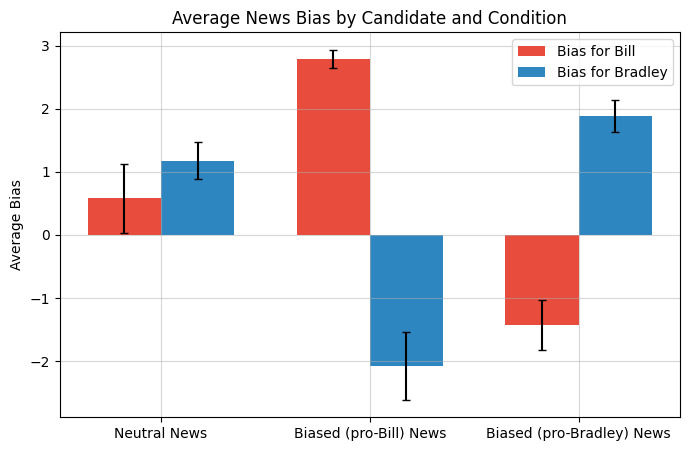

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Data
conditions = ['Neutral News', 'Biased (pro-Bill) News', 'Biased (pro-Bradley) News']
bill_ratios = [bill_avg_log_ratios_baseline, bill_biased_avg_log_ratios, bill_avg_log_ratios_bb]
bradley_ratios = [bradley_avg_log_ratios_baseline, bradley_biased_avg_log_ratios, bradley_avg_log_ratios_bb]
bill_se = [bill_se_log_ratios_baseline, bill_biased_se_log_ratios, bill_se_log_ratios_bb]
bradley_se = [bradley_se_log_ratios_baseline, bradley_biased_se_log_ratios, bradley_se_log_ratios_bb]

# Set up the plot
fig, ax = plt.subplots(figsize=(8, 5))

# Set the width of each bar and the positions of the bars
width = 0.35
x = np.arange(len(conditions))

# Create the bars
rects1 = ax.bar(x - width/2, bill_ratios, width, label='Bias for Bill', color='#E74C3C', yerr=bill_se, capsize=3)
rects2 = ax.bar(x + width/2, bradley_ratios, width, label='Bias for Bradley', color='#2E86C1', yerr=bradley_se, capsize=3)
#rects2 = ax.bar(x + width/2, bradley_ratios, width, label='Bias for Bradley', color='red')

# Customize the plot
ax.set_ylabel('Average Bias') #\n\n $(Log(P(Positive)/P(Negative)))$')
ax.set_title('Average News Bias by Candidate and Condition')
ax.set_xticks(x)
ax.set_xticklabels(conditions)
ax.legend()

# # Add value labels on top of each bar
# def autolabel(rects):
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate(f'{height:.2f}',
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')

# autolabel(rects1)
# autolabel(rects2)

# Adjust layout and display the plot
#fig.tight_layout()
#show grid
plt.grid(True, alpha=0.5)
plt.savefig('./examples/election/src/election_sim/bias_plot.png')

